In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import h3pandas 
sys.path.append('../../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../../scripts/')
import create_dataset_utils as cdu
import paired_embeddings_models as pem
sys.path.append('../../../cnn-land-cover/scripts/')
import land_cover_analysis as lca 
import land_cover_visualisation as lcv
import shapely
from tqdm import tqdm, tqdm_notebook
import torch

In [3]:
df_mapping_locs, _ = cdu.load_names_unique_locs()
df_mapping_locs.head()

,tuple_coords,footprintWKT,count,name_loc
0,"(-2.165105, 50.956811)","POLYGON((-2.17221 50.9523,-2.17221 50.96132,-2...",53410,UKBMS_loc-0000
1,"(-2.646667, 50.775285)","POLYGON((-2.6537 50.77075,-2.6537 50.77982,-2....",51809,UKBMS_loc-0001
2,"(-0.828484, 50.888106)","POLYGON((-0.8357 50.88368,-0.8357 50.89253,-0....",48596,UKBMS_loc-0002
3,"(-1.966038, 50.59722)","POLYGON((-1.97311 50.59273,-1.97311 50.60171,-...",46522,UKBMS_loc-0003
4,"(-0.22994099999999998, 52.409243)","POLYGON((-0.23747 52.40486,-0.23747 52.41363,-...",44130,UKBMS_loc-0004


In [4]:
df_per_loc = cdu.load_species_dataset()
df_per_loc.head()

,tuple_coords,Melanargia galathea,Pieris napi,Aphantopus hyperantus,Aglais io,Polyommatus icarus,Vanessa atalanta,Lycaena phlaeas,Pararge aegeria,Gonepteryx rhamni,...,Tyria jacobaeae,Euclidia glyphica,Odezia atrata,Melitaea cinxia,Carterocephalus palaemon,Nymphalis polychloros,Nymphalis antiopa,Erebia epiphron,n_visits,name_loc
0,"(-7.824283, 54.259247)",0.0,0.696970,0.242424,0.333333,0.272727,0.060606,0.121212,0.545455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,UKBMS_loc-1044
1,"(-7.457325, 54.15933)",0.0,0.419355,0.387097,0.354839,0.000000,0.064516,0.000000,0.870968,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,UKBMS_loc-1420
2,"(-6.949025, 54.883646)",0.0,0.363636,0.409091,0.045455,0.000000,0.090909,0.000000,0.818182,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,UKBMS_loc-0979
3,"(-6.753205, 55.169256)",0.0,0.448276,0.413793,0.034483,0.448276,0.034483,0.034483,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,UKBMS_loc-0925
4,"(-6.405594, 55.228089)",0.0,0.718750,0.187500,0.375000,0.437500,0.093750,0.500000,0.218750,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32,UKBMS_loc-0962


In [16]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='top_20')


Found 1336 out of 1455 images in the image folder.
Sorting data by name_loc.
Only keeping top 20 species with most observations.


In [102]:
ds.df_presence[ds.species_list].mean(0)

Thymelicus sylvestris     0.128541
Celastrina argiolus       0.147638
Ochlodes venata           0.161267
Vanessa cardui            0.184303
Anthocharis cardamines    0.185663
Lycaena phlaeas           0.192857
Aglais urticae            0.198037
Polygonia c-album         0.217640
Aphantopus hyperantus     0.241885
Pyronia tithonus          0.244390
Coenonympha pamphilus     0.265762
Vanessa atalanta          0.270377
Gonepteryx rhamni         0.277031
Aglais io                 0.309221
Polyommatus icarus        0.371392
Pieris napi               0.376350
Pieris brassicae          0.436822
Maniola jurtina           0.468321
Pieris rapae              0.512473
Pararge aegeria           0.595935
dtype: float64

In [76]:
im, pres = ds[0]

/Users/t.vanderplas/repos/PECL/notebooks/try-out/../../scripts/paired_embeddings_models.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


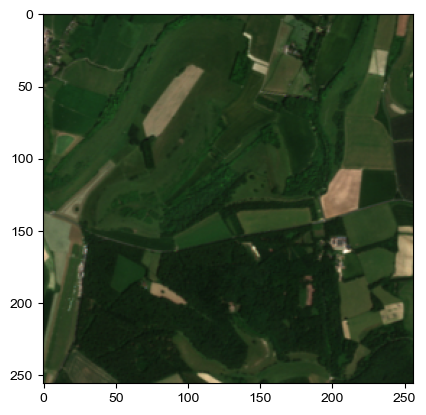

In [84]:
plt.imshow(np.swapaxes(im[:3, ...], 0, 2) )

In [106]:
im_enc = pem.ImageEncoder(n_species=ds.n_species, n_bands=4, freeze_resnet=True)

In [ ]:
dict_models = {}
i_model = 0
for freeze in [True, False]:
    dict_models[i_model] = pem.train_pecl(training_method='pecl', pecl_distance_metric='euclidean',
                        n_epochs_max=200, batch_size=32, freeze_resnet=freeze)
    i_model += 1

In [10]:
# dict_models

In [26]:
i_model += 1
dict_models[i_model] = pem.train_pecl(training_method='pecl', 
                    pecl_distance_metric='euclidean',
                    normalise_embedding=True,
                    # species_process
                    n_epochs_max=10, batch_size=32, freeze_resnet=True,
                    n_layers_mlp=2)


Seed set to 42
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pytorch version is 2.2.0.dev20231210
Found 1336 out of 1455 images in the image folder.
Shuffling data.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Starting training at 2024-02-08 16:47:47.906906 with 10 epochs.



  | Name             | Type       | Params
------------------------------------------------
0 | resnet           | ResNet     | 11.5 M
1 | prediction_model | Sequential | 2.0 K 
------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.843    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/urllib3/util/connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/socket.py", line 955, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/Users/t.vanderplas/anaconda3/envs/satbird/lib/

-- Finished training at 2024-02-08 16:55:45.259597.


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [14]:
dict_models[0]

ImageEncoder(
  (resnet): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [23]:
tmp_model = dict_models[2]
pred = tmp_model.forward(ds[0][0].to('mps'))
pred

tensor([[ 0.3195, -0.6520,  0.3982, -0.5563,  0.0942, -0.7129,  0.2797, -1.0563,
         -1.0933,  0.0729,  0.1597, -0.2053, -0.1574, -1.3890, -0.7380,  0.4742,
         -1.0301,  0.2929,  0.3572, -0.8506,  0.0579,  0.8525, -1.0758, -0.5424,
         -1.3195,  0.2133, -0.7246, -0.3904,  0.1759, -0.3455, -0.5820,  1.7507]],
       device='mps:0', grad_fn=<LinearBackward0>)

In [24]:
pred.shape

torch.Size([1, 32])

## To try:
- normalise image encoding (L2 normalise?)
- Use different distance; something like that distr from SCE?
- But first, implement prediction task to gauge performance (accuracy, top-k accuracy etc)

### Different distance:
SupCon paper:

Normally for CL, if `z = MLP ( ENC (x))`, and sample `i` has one positive sample `j`, the loss function is:

$L_{CL} = - \sum_i \log \frac{\exp (z_i \cdot z_j(i) / \tau)}{\sum_{k \neq i} \exp (z_i \cdot z_k / \tau)} $

The intuition being that for positive pairs, any distance between them is loss. This is soft-maxed for whatever reason. (Not sure why positive pair is excluded from denominator..) 

For SupCon, they develop an equivalent for more than 1 positive pairs:

$ L_{SupCon} = \sum_i \frac{-1}{| P(i) |} \sum_{p \in P} \log \frac{\exp (z_i \cdot z_p(i) / \tau)}{\sum_{k \neq i} \exp (z_i \cdot z_k / \tau)} $

For my idea, where `s` is the species representation, maybe:

$ d_{ij}^z = - \log \frac{\exp (z_i \cdot z_j / \tau)}{\sum_{k \neq i} \exp (z_i \cdot z_k / \tau)} $

$ d_{ij}^s = - \log \frac{\exp (s_i \cdot s_j / \tau)}{\sum_{k \neq i} \exp (s_i \cdot s_k / \tau)} $

Or should the normalisation in denominator be for all pairs $\sum_{i, j}$ instead of only pairs with $i$ ($\sum_j$) ..? Every distance will be very small I presume (dominated by a few ones.).

$ L_{PECL} = \sum_i \sum_{j > i} l(d_ij^z - d_ij^s) $ with $l = l_1, l_2, ..$

Where this is done per batch -- as also done in SupCon paper I understand, so $N$ is batch size. 